# Задание 6. Изучение свойств опционов

## Цель задания:
### 1. Получить навык работы с биржевой информацией CBOE 
### 2. Изучить свойства моделей CRR и BSM
### 3. Построить простые опционные стратегии
### 4. Сравнить теоретические и рыночные цены опционов
### 5. Изучить показатель чувствительности дельта и построить реплицированный портфель
### 6. Изучить показатель чувствительности вега и рассчитать подразумеваемую волатильность

### В прилагаемом файле содержится информация об опционах на акции трех американских компаний - Apple, Microsoft и Exxon Mobile

### Рекомендуемая литература:
### 1.Y.Hilpish "Derivatives Analytics with Python"
### 2.Y.Hilpish  "Python for Finance"
### 3.J.M. Weiming "Mastering Python for Finance"

## 1. Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
from datetime import datetime,timedelta

In [3]:
from __future__ import division

In [4]:
import networkx as nx # библиотеке визуализации графов

In [5]:
import matplotlib.pyplot as plt # графическая библиотека
%matplotlib inline 

## 2. Загрузка и подготовка данных

In [6]:
path='/home/maxime/Documentos/Derivatives/'

### Данные по опционам

In [7]:
cboe_options=pd.read_csv(path+'UnderlyingOptionsEODCalcs_2019-02-04.csv',parse_dates=True)

In [8]:
cboe_options.columns

Index([u'underlying_symbol', u'quote_date', u'root', u'expiration', u'strike',
       u'option_type', u'open', u'high', u'low', u'close', u'trade_volume',
       u'bid_size_1545', u'bid_1545', u'ask_size_1545', u'ask_1545',
       u'underlying_bid_1545', u'underlying_ask_1545',
       u'implied_underlying_price_1545', u'active_underlying_price_1545',
       u'implied_volatility_1545', u'delta_1545', u'gamma_1545', u'theta_1545',
       u'vega_1545', u'rho_1545', u'bid_size_eod', u'bid_eod', u'ask_size_eod',
       u'ask_eod', u'underlying_bid_eod', u'underlying_ask_eod', u'vwap',
       u'open_interest', u'delivery_code'],
      dtype='object')

In [9]:
cboe_options.head()

,underlying_symbol,quote_date,root,expiration,strike,option_type,open,high,low,close,...,rho_1545,bid_size_eod,bid_eod,ask_size_eod,ask_eod,underlying_bid_eod,underlying_ask_eod,vwap,open_interest,delivery_code
0,AAPL,2019-02-04,AAPL,2019-02-08,100.0,C,0.0,0.0,0.0,0.0,...,0.9958,15,71.05,42,71.40,171.26,171.27,0.0,12,NaN
1,AAPL,2019-02-04,AAPL,2019-02-08,100.0,P,0.0,0.0,0.0,0.0,...,-0.0012,0,0.00,102,0.01,171.26,171.27,0.0,464,NaN
2,AAPL,2019-02-04,AAPL,2019-02-08,105.0,C,0.0,0.0,0.0,0.0,...,1.0550,15,66.05,138,66.50,171.26,171.27,0.0,10,NaN
3,AAPL,2019-02-04,AAPL,2019-02-08,105.0,P,0.0,0.0,0.0,0.0,...,-0.0013,0,0.00,92,0.01,171.26,171.27,0.0,115,NaN
4,AAPL,2019-02-04,AAPL,2019-02-08,110.0,C,0.0,0.0,0.0,0.0,...,1.1147,10,61.10,131,61.50,171.26,171.27,0.0,4,NaN


In [10]:
cboe_options.dtypes

underlying_symbol                 object
quote_date                        object
root                              object
expiration                        object
strike                           float64
option_type                       object
open                             float64
high                             float64
low                              float64
close                            float64
trade_volume                       int64
bid_size_1545                      int64
bid_1545                         float64
ask_size_1545                      int64
ask_1545                         float64
underlying_bid_1545              float64
underlying_ask_1545              float64
implied_underlying_price_1545    float64
active_underlying_price_1545     float64
implied_volatility_1545          float64
delta_1545                       float64
gamma_1545                       float64
theta_1545                       float64
vega_1545                        float64
rho_1545        

In [11]:
cboe_options['expiration']=cboe_options['expiration'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d')) 
### преобразование поля даты в необходимый формат

In [12]:
cboe_options['quote_date']=cboe_options['quote_date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d')) 

### Базовый актив

In [13]:
msft=pd.read_csv(path+'MSFT.csv')

In [14]:
msft

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-31,103.800003,105.220001,103.180000,104.430000,104.430000,55636400
1,2019-02-01,103.779999,104.099998,102.349998,102.779999,102.779999,35535700
2,2019-02-04,102.870003,105.800003,102.769997,105.739998,105.739998,31315100
3,2019-02-05,106.059998,107.269997,105.959999,107.220001,107.220001,27303200


In [15]:
msft.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [16]:
msft['Date']=msft['Date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d')) 

## 3. Выбор опционов для анализа 

In [17]:
date='2019-02-04'# дата расчетов

In [18]:
quote_date=datetime.strptime(date, '%Y-%m-%d')# дата расчетов
quote_date

datetime.datetime(2019, 2, 4, 0, 0)

In [19]:
expiration_date='2019-02-15'# дата экспирации

In [20]:
expiration_date=datetime.strptime(expiration_date,'%Y-%m-%d')

In [21]:
# цена спот в дату расчета
S_0=float(msft[msft.Date==quote_date]['Close'])
print(S_0)

105.739998


In [22]:
# количество дней до экспирации
days=(expiration_date-quote_date).days
T=days/250

In [23]:
div_y=0.0172 # непрерывная дивидендная ставка (можно взять с сайта yahoo)

In [24]:
# полный набор страйков
strikes=np.array(cboe_options[(cboe_options.quote_date==quote_date)&(cboe_options.underlying_symbol=='MSFT')\
             &(cboe_options.expiration==expiration_date)]['strike'].unique())

In [25]:
strikes

array([  50. ,   55. ,   60. ,   65. ,   70. ,   75. ,   75.5,   76. ,
         76.5,   77. ,   77.5,   78. ,   78.5,   79. ,   79.5,   80. ,
         80.5,   81. ,   81.5,   82. ,   82.5,   83. ,   83.5,   84. ,
         84.5,   85. ,   85.5,   86. ,   86.5,   87. ,   87.5,   88. ,
         88.5,   89. ,   89.5,   90. ,   90.5,   91. ,   91.5,   92. ,
         92.5,   93. ,   94. ,   95. ,   96. ,   97. ,   97.5,   98. ,
         99. ,   99.5,  100. ,  101. ,  102. ,  103. ,  104. ,  105. ,
        106. ,  107. ,  108. ,  109. ,  110. ,  111. ,  112. ,  113. ,
        114. ,  115. ,  116. ,  117. ,  118. ,  119. ,  120. ,  125. ,
        130. ,  135. ,  140. ,  145. ,  150. ])

In [26]:
# страйк ATM 
index_ATM=np.argmin(np.abs(strikes-S_0))
index_ATM

56

In [27]:
# вспомогательный индекс для построения списка страйков
strike_range_index=5

In [28]:
# максимальный и минимальный индексы для  списка страйков
index_min=max(0,index_ATM-strike_range_index)
index_max=min(len(strikes)-1,index_ATM+strike_range_index)
print(index_min,index_max)

(51, 61)


In [29]:
# создание списка страйков
strikes_range=strikes[index_min:index_max]
max(strikes_range)

110.0

In [30]:
# массив данных по выбранным опционам колл
cboe_MSFT_call=cboe_options[(cboe_options.quote_date==quote_date)&(cboe_options.underlying_symbol=='MSFT')\
&(cboe_options.option_type=='C')&(cboe_options.expiration==expiration_date)\
&(cboe_options.strike<=max(strikes_range))&(cboe_options.strike>=\
min(strikes_range))][['strike','high','low','close','delta_1545','gamma_1545','vega_1545','implied_volatility_1545']]

In [31]:
cboe_MSFT_call

,strike,high,low,close,delta_1545,gamma_1545,vega_1545,implied_volatility_1545
1654,101.0,5.00,3.85,4.95,0.8507,0.0521,0.0426,0.2437
1656,102.0,4.25,2.44,4.25,0.7973,0.0653,0.0517,0.2359
1658,103.0,3.40,1.85,3.30,0.7307,0.0793,0.0605,0.2274
1660,104.0,2.67,1.25,2.55,0.6500,0.0929,0.0679,0.2177
1662,105.0,2.04,0.61,2.02,0.5538,0.1023,0.0724,0.2110
1664,106.0,1.48,0.60,1.39,0.4490,0.1056,0.0725,0.2045
1666,107.0,1.01,0.39,0.92,0.3438,0.1005,0.0674,0.1998
1668,108.0,0.66,0.29,0.59,0.2464,0.0881,0.0578,0.1954
1670,109.0,0.40,0.18,0.38,0.1669,0.0705,0.0458,0.1936
1672,110.0,0.30,0.09,0.20,0.1056,0.0520,0.0334,0.1917


In [32]:
# массив данных по выбранным опционам пут
cboe_MSFT_put=cboe_options[(cboe_options.quote_date==quote_date)&(cboe_options.underlying_symbol=='MSFT')\
&(cboe_options.option_type=='P')&(cboe_options.expiration==expiration_date)\
&(cboe_options.strike<=max(strikes_range))&(cboe_options.strike>=\
min(strikes_range))][['strike','high','low','close','delta_1545','gamma_1545','vega_1545','implied_volatility_1545']]

In [33]:
cboe_MSFT_put

,strike,high,low,close,delta_1545,gamma_1545,vega_1545,implied_volatility_1545
1655,101.0,0.65,0.30,0.30,-0.1432,0.0520,0.0414,0.2374
1657,102.0,1.12,0.40,0.40,-0.1960,0.0659,0.0507,0.2289
1659,103.0,1.70,0.57,0.57,-0.2629,0.0810,0.0598,0.2199
1661,104.0,1.88,0.83,0.83,-0.3474,0.0945,0.0677,0.2133
1663,105.0,2.83,1.16,1.20,-0.4452,0.1046,0.0724,0.2062
1665,106.0,3.00,1.60,1.68,-0.5521,0.1074,0.0725,0.2010
1667,107.0,3.15,2.19,2.23,-0.6582,0.1015,0.0673,0.1974
1669,108.0,4.60,2.90,2.90,-0.7575,0.0888,0.0573,0.1921
1671,109.0,3.80,3.80,3.80,-0.8386,0.0705,0.0448,0.1894
1673,110.0,6.45,4.40,4.49,-0.9115,0.0492,0.0294,0.1779


## 4. Модель CRR

### Алгоритм  модели биномиального дерева CRR и соответствующие формулы приведены в лекционных материалах. Программная реализация модели осуществляется с помощью создания класса. Класс объединяет методы (функции) и переменные или, иначе, реализует механизм инкапсуляции, являющийся важнейшим элементом объектно-ориентированного программирования.

In [34]:
class CRR:
    def __init__(self,S_0,K,r,T,N,sigma,div=0,t=0,is_call=True,is_european=True):
        self._S_0=S_0
        self._K=K
        self._r=r
        self._div=div
        self._T=T
        self._N=N
        self._sigma=sigma
        self._t=t
        self._is_call=is_call  
        self._is_european=is_european

    def __set_up__(self):
        self._dt=T/N
        self._df=np.exp(-(self._r-self._div)*self._dt)
        self._u=np.exp(self._sigma*np.sqrt(self._dt))
        self._d=1/self._u
        self._p=(np.exp((self._r-self._div)*self._dt)-self._d)/(self._u-self._d)
        self._q=1-self._p
    
    def __path_gen__(self):
            self._S=[np.array([self._S_0])]
            for i in range(self._N):
                prev=self._S[-1]
                st=np.concatenate((prev*self._u,[prev[-1]*self._d]))
                self._S.append(st)
       
    def __initialize_payoffs__(self):
            final_state=self._S[N]
            return np.maximum(0,(final_state-self._K)) if self._is_call else np.maximum(0,(self._K-final_state))
        
    def __check_early_ex__(self,i,payoffs):
            early_payoffs=(self._S[i]-self._K) if self._is_call else (self._K-self._S[i])
            return np.maximum(early_payoffs,payoffs)                                                                
        
    def __traverse_tree__(self,payoffs):                                        
            for i in reversed(range(self._N)):
                payoffs=(payoffs[:-1]*self._p+payoffs[1:]*self._q)*self._df
                #print(payoffs)
                if not self._is_european:
                    payoffs=self.__check_early_ex__(i,payoffs)
            return payoffs 
                       
    def get_price(self):
            self.__set_up__()
            self.__path_gen__()                  
            payoffs_init=self.__initialize_payoffs__()
            payoffs=self.__traverse_tree__(payoffs_init)                 
            return payoffs[0] 
    
    def get_path(self):
        self.__set_up__()
        self.__path_gen__() 
        return self._S
    
    def get_prob(self):
        self.__set_up__()
        return self._p,self._q
    
    def get_param(self):
        self.__set_up__()
        return self._u,self._d

### Реализация модели CRR 

In [35]:
K=108 # страйк
r=0.025 # процентная ставка
N=4 # количестов шагов для построения биномиального дерева
sigma=0.2# волатильность

In [36]:
option_call=CRR(S_0,K,r,T,N,sigma,is_call=True,div=div_y,is_european=True)

In [37]:
option_call.get_price()

0.98610273051703057

In [38]:
S=option_call.get_path()# биномиальное дерево

In [39]:
S

[array([ 105.739998]),
 array([ 107.98144522,  103.54507808]),
 array([ 110.27040602,  105.739998  ,  101.39571967]),
 array([ 112.60788758,  107.98144522,  103.54507808,   99.29097701]),
 array([ 114.99491842,  110.27040602,  105.739998  ,  101.39571967,
          97.22992399])]

### Визуализация дерева

In [40]:
G=nx.Graph()

In [41]:
for i in range(0,N+1):
        for j in range(1,i+2):
            if i<N:
                G.add_edge((i,j),(i+1,j))
                G.add_edge((i,j),(i+1,j+1))

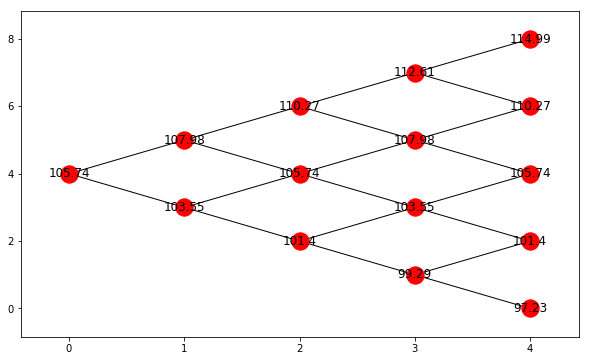

In [42]:
plt.figure(figsize=(10,6))
posG={}
labels={}
i=0
for node in   G.nodes():
        posG[node]=(node[0],N+2+node[0]-2*node[1])
        i,j=node
        labels[node]=round(S[i][j-1],2)
nx.draw_networkx_nodes(G,posG)
nx.draw_networkx_edges(G,posG)
_=nx.draw_networkx_labels(G,posG,labels)

In [43]:
option_call.get_prob()# риск-нейтральные вероятности

(0.49680126304845612, 0.50319873695154382)

In [44]:
option_call.get_param()# параметры u и d

(1.0211977233170073, 0.97924229281656261)

In [45]:
option_put=CRR(S_0,K,r,T,N,sigma,is_call=False,div=div_y,is_european=True)

In [46]:
option_put.get_price()

3.2090454902464218

### Паритет пут-колл

In [47]:
K*np.exp(-r*(T-0))+option_call.get_price()

108.86736804656562

In [48]:
np.exp(-div_y*(T-0))*S_0+option_put.get_price()

108.8690497332157

## 5. Модель BSM (Black Scholes Merton)

###  Модель Блэка-Шоулза и соответствующие формулы приведены в лекционных материалах. Программная реализация модели осуществляется с помощью создания класса. 

In [49]:
class BSM:
        def __init__(self,S_0,K,r,T,sigma,div=0,t=0,is_call=True):
            self._S_0=S_0
            self._K=K
            self._r=r
            self._div=div
            self._T=T
            self._sigma=sigma
            self._t=t
            self._is_call=is_call  
       
        def __d_values__(self):
            self._d1=(np.log(self._S_0/self._K)+(self._r-self._div+0.5*self._sigma**2)*(self._T-self._t))/(self._sigma*np.sqrt(self._T-self._t))
            self._d2=self._d1-self._sigma*np.sqrt(self._T-self._t)
            
        def __N_d__(self,d_value):
            return stats.norm.cdf(d_value)
        
        def __price__(self):
            return (np.exp(-self._div*\
            (self._T-self._t))*self._S_0*self.__N_d__(self._d1)-np.exp(-self._r*\
            (self._T-self._t))*self._K*self.__N_d__(self._d2)) if self._is_call \
            else (np.exp(-self._r*(self._T-self._t))*self._K*self.__N_d__(-self._d2)- np.exp(-self._div*\
            (self._T-self._t))*self._S_0*self.__N_d__(-self._d1))
            
        def get_price(self):
            self.__d_values__()
            price=self.__price__()
            return price
        
        def get_delta(self):
            self.__d_values__()
            return self.__N_d__(self._d1) if self._is_call else  self.__N_d__(self._d1)-1
        
        def get_vega(self):
            self.__d_values__()
            return self._S_0*stats.norm.pdf(self._d1)*np.sqrt(self._T-self._t)

### Реализация модели BSM 

In [50]:
K=105
r=0.024
sigma=0.2# годовое значение
call=True

In [51]:
option_call=BSM(S_0,K,r,T,sigma,div=div_y,is_call=True)

In [52]:
option_call.get_price()

2.1739809537005854

In [53]:
option_call.get_delta() # дельта опциона

0.5775029306678946

In [54]:
option_call.get_vega()# вега опциона

8.6811143624548475

In [55]:
option_put=BSM(S_0,K,r,T,sigma,div=div_y,is_call=False)

In [56]:
option_put.get_price()

1.4031552347690379

In [57]:
option_put.get_delta()

-0.4224970693321054

In [58]:
option_put.get_vega()

8.6811143624548475

### Паритет пут-колл

In [59]:
K*np.exp(-r*(T-0))+option_call.get_price()

107.06315947773831

In [60]:
np.exp(-div_y*(T-0))*S_0+option_put.get_price()

107.06315947773831

## 5. Опиционные стратегии

###  Bull spread

In [61]:
bull_spread_setup=pd.DataFrame(zip(['Call','Call'],[104,108],
[CRR(S_0,104,r,T,N,sigma,is_call=True,div=div_y,is_european=False).get_price(),\
CRR(S_0,108,r,T,N,sigma,is_call=True,div=div_y,is_european=False).get_price()],['Buy','Sell']),\
                               columns=['Type','Strike','Price','Buy/Sell'])

In [62]:
bull_spread_setup

,Type,Strike,Price,Buy/Sell
0,Call,104,2.865833,Buy
1,Call,108,0.984652,Sell


In [63]:
bull_spread_result=pd.DataFrame(zip(range(100,111),np.maximum(range(100,111)-bull_spread_setup.iloc[0,1],0)-bull_spread_setup.iloc[0,2],\
-np.maximum((range(100,111)-bull_spread_setup.iloc[1,1]),0)+bull_spread_setup.iloc[1,2]),columns=['Spot','Call1','Call2'])

In [64]:
bull_spread_result['Result']=bull_spread_result['Call1']+bull_spread_result['Call2']

In [65]:
bull_spread_result

,Spot,Call1,Call2,Result
0,100,-2.865833,0.984652,-1.88118
1,101,-2.865833,0.984652,-1.88118
2,102,-2.865833,0.984652,-1.88118
3,103,-2.865833,0.984652,-1.88118
4,104,-2.865833,0.984652,-1.88118
5,105,-1.865833,0.984652,-0.88118
6,106,-0.865833,0.984652,0.11882
7,107,0.134167,0.984652,1.11882
8,108,1.134167,0.984652,2.11882
9,109,2.134167,-0.015348,2.11882


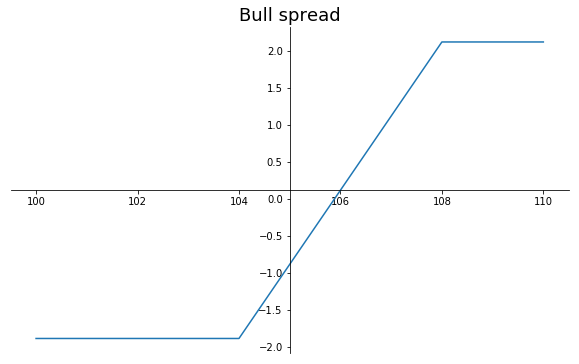

In [66]:
plt.figure(figsize=(10,6))
plt.plot(bull_spread_result.Spot,bull_spread_result.Result)
ax=plt.gca()
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_ticks_position('left')
_=plt.title('Bull spread',fontsize=18)

###  Long straddle

In [67]:
long_straddle_setup=pd.DataFrame(zip(['Call','Put'],[106,106],
[CRR(S_0,106,r,T,N,sigma,is_call=True,div=div_y,is_european=False).get_price(),\
CRR(S_0,106,r,T,N,sigma,is_call=False,div=div_y,is_european=False).get_price()],['Buy','Buy']),\
                               columns=['Type','Strike','Price','Buy/Sell'])

In [68]:
long_straddle_setup

,Type,Strike,Price,Buy/Sell
0,Call,106,1.599122,Buy
1,Put,106,1.833427,Buy


In [69]:
long_straddle_result=pd.DataFrame(zip(range(100,111),np.maximum(range(100,111)-long_straddle_setup.iloc[0,1],0)-long_straddle_setup.iloc[0,2],\
np.maximum(long_straddle_setup.iloc[1,1]-(range(100,111)),0)-long_straddle_setup.iloc[1,2]),columns=['Spot','Call','Put'])

In [70]:
long_straddle_result['Result']=long_straddle_result['Call']+long_straddle_result['Put']

In [71]:
long_straddle_result

,Spot,Call,Put,Result
0,100,-1.599122,4.166573,2.567451
1,101,-1.599122,3.166573,1.567451
2,102,-1.599122,2.166573,0.567451
3,103,-1.599122,1.166573,-0.432549
4,104,-1.599122,0.166573,-1.432549
5,105,-1.599122,-0.833427,-2.432549
6,106,-1.599122,-1.833427,-3.432549
7,107,-0.599122,-1.833427,-2.432549
8,108,0.400878,-1.833427,-1.432549
9,109,1.400878,-1.833427,-0.432549


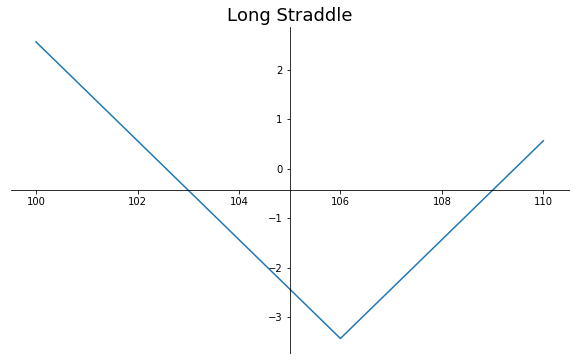

In [72]:
fig=plt.figure(figsize=(10,6))
plt.plot(long_straddle_result.Spot,long_straddle_result.Result)
ax=plt.gca()
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
_=plt.title('Long Straddle',fontsize=18)

## 6. Сравнение теоретических и рыночных цен

### В данном разделе задания рассчитаем теоретические цены опционов с помощью моделей CRR и BSM  и сравним их с рыночными ценами

In [73]:
N=1000# количество шагов для модели CRR

### Call

In [74]:
cboe_MSFT_call['American_div_Bin']=cboe_MSFT_call.apply\
(lambda row: np.round(CRR(S_0,row['strike'],r,T,N,row['vega_1545'],is_call=True,div=div_y,is_european=False).get_price(),2),axis=1)

In [75]:
cboe_MSFT_call['European_div_Bin']=cboe_MSFT_call.apply\
(lambda row: np.round(CRR(S_0,row['strike'],r,T,N,row['vega_1545'],is_call=True,div=div_y,is_european=True).get_price(),2),axis=1)

In [76]:
cboe_MSFT_call['BSM_div']=cboe_MSFT_call.apply(lambda row: np.round(BSM(S_0,row['strike'],r,T,row['vega_1545'],is_call=True).get_price(),2),axis=1)

In [77]:
cboe_MSFT_call

,strike,high,low,close,delta_1545,gamma_1545,vega_1545,implied_volatility_1545,American_div_Bin,European_div_Bin,BSM_div
1654,101.0,5.00,3.85,4.95,0.8507,0.0521,0.0426,0.2437,4.77,4.77,4.85
1656,102.0,4.25,2.44,4.25,0.7973,0.0653,0.0517,0.2359,3.77,3.77,3.85
1658,103.0,3.40,1.85,3.30,0.7307,0.0793,0.0605,0.2274,2.78,2.78,2.86
1660,104.0,2.67,1.25,2.55,0.6500,0.0929,0.0679,0.2177,1.86,1.86,1.93
1662,105.0,2.04,0.61,2.02,0.5538,0.1023,0.0724,0.2110,1.10,1.10,1.15
1664,106.0,1.48,0.60,1.39,0.4490,0.1056,0.0725,0.2045,0.53,0.53,0.57
1666,107.0,1.01,0.39,0.92,0.3438,0.1005,0.0674,0.1998,0.18,0.18,0.19
1668,108.0,0.66,0.29,0.59,0.2464,0.0881,0.0578,0.1954,0.02,0.02,0.03
1670,109.0,0.40,0.18,0.38,0.1669,0.0705,0.0458,0.1936,0.00,0.00,0.00
1672,110.0,0.30,0.09,0.20,0.1056,0.0520,0.0334,0.1917,0.00,0.00,0.00


### Put

In [78]:
cboe_MSFT_put['American_div_Bin']=cboe_MSFT_put.apply\
(lambda row: np.round(CRR(S_0,row['strike'],r,T,N,row['vega_1545'],is_call=False,div=div_y,is_european=False).get_price(),2),axis=1)

In [79]:
cboe_MSFT_put['European_div_Bin']=cboe_MSFT_put.apply\
(lambda row: np.round(CRR(S_0,row['strike'],r,T,N,row['vega_1545'],is_call=False,div=div_y,is_european=True).get_price(),2),axis=1)

In [80]:
cboe_MSFT_put['BSM_div']=cboe_MSFT_put.apply(lambda row: np.round(BSM(S_0,row['strike'],r,T,row['vega_1545'],is_call=False).get_price(),2),axis=1)

In [81]:
cboe_MSFT_put

,strike,high,low,close,delta_1545,gamma_1545,vega_1545,implied_volatility_1545,American_div_Bin,European_div_Bin,BSM_div
1655,101.0,0.65,0.30,0.30,-0.1432,0.0520,0.0414,0.2374,0.00,0.00,0.00
1657,102.0,1.12,0.40,0.40,-0.1960,0.0659,0.0507,0.2289,0.00,0.00,0.00
1659,103.0,1.70,0.57,0.57,-0.2629,0.0810,0.0598,0.2199,0.01,0.01,0.01
1661,104.0,1.88,0.83,0.83,-0.3474,0.0945,0.0677,0.2133,0.09,0.09,0.08
1663,105.0,2.83,1.16,1.20,-0.4452,0.1046,0.0724,0.2062,0.33,0.33,0.30
1665,106.0,3.00,1.60,1.68,-0.5521,0.1074,0.0725,0.2010,0.77,0.76,0.72
1667,107.0,3.15,2.19,2.23,-0.6582,0.1015,0.0673,0.1974,1.41,1.40,1.34
1669,108.0,4.60,2.90,2.90,-0.7575,0.0888,0.0573,0.1921,2.27,2.25,2.17
1671,109.0,3.80,3.80,3.80,-0.8386,0.0705,0.0448,0.1894,3.26,3.23,3.15
1673,110.0,6.45,4.40,4.49,-0.9115,0.0492,0.0294,0.1779,4.26,4.23,4.14


## 7. Показатель чувствительности $\Delta$

###  Delta - hedging. Расчет показателя $\Delta$ приведен в лекционных материалах.

### $C=\Delta S-B$
### $P=\Delta S+B$

### На каждом шаге мы ребалансируем портфель с учетом равенства:
### $dP=\Delta dS$ (для опциона колл расчет аналогичный)
### Ребалансировка учитывает проценты по денежной позиции

### В данном задании будем моделировать динамику актива с помощью геометрического броуновского движения

### $S_{i+1}=S_iexp((r-0.5\sigma^2)\Delta_t+\sigma\sqrt{\Delta_t}Z_t)$

In [82]:
def GBM(n_step,S_0,r,sigma,dt):
    S=np.zeros(n_step)
    S[0]=S_0
    rand=np.random.standard_normal(n_step)
    for i in range(1,n_step):
        S[i]=S[i-1]*np.exp((r-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*rand[i])
    return S    

### Реализуем пошаговый процесс репикации опциона (создания портфеля, воспроизводящего стоимость опциона)

In [112]:
r=0.0024
T=30/250
sigma=0.2# годовое значение
n_step=int(T*250)
dt=1/250

In [113]:
S=np.zeros(n_step) # массив цен акци
Delta=np.zeros(n_step)# массив дельт
Option_theor=np.zeros(n_step)# массив теоретических цен
S_Delta=np.zeros(n_step)# произведение цен и дельт
Bond=np.zeros(n_step)# денежная позиция
Replicate=np.zeros(n_step)# репликация

### Расчет первоначальных значений параметров

In [114]:
S[0]=S_0

In [115]:
option=BSM(S_0,K,r,T,sigma,t=0,is_call=False)

In [116]:
Option_theor[0]=option.get_price()
Replicate[0]=Option_theor[0]
print(Option_theor[0])

2.5424482978


In [117]:
Delta[0]=option.get_delta()
S_Delta[0]=S[0]*Delta[0]
print(Delta[0])

-0.444265008114


In [118]:
Bond[0]=Option_theor[0]-S_Delta[0]
print(Bond[0])

49.5190293672


In [119]:
S=GBM(n_step,S_0,r,sigma,dt)# моделирование динамики

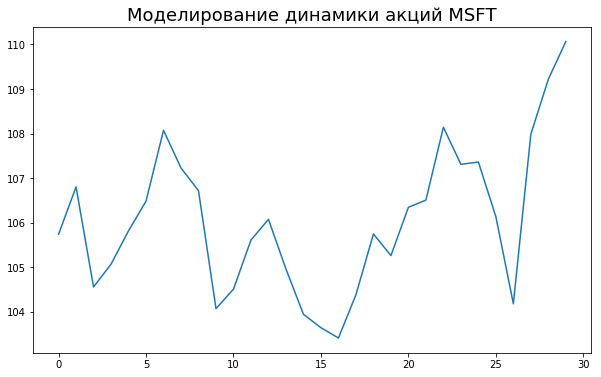

In [120]:
plt.figure(figsize=(10,6))
_=plt.plot(S)
_=plt.title(u'Моделирование динамики акций MSFT',fontsize=18)

### Пошаговая репликация

In [121]:
for i in range(1,n_step):
    option=BSM(S[i],K,r,T,sigma,is_call=False,t=i/250)
    Option_theor[i]=option.get_price()
    Delta[i]=option.get_delta()
    S_Delta[i]=S[i]*Delta[i]
    Replicate[i]=Replicate[i-1]+(S[i]-S[i-1])*Delta[i-1]+Bond[i-1]*(np.exp(r/250)-1)
    Bond[i]=Option_theor[i]-S_Delta[i]

In [122]:
pd.DataFrame(zip(S,Option_theor,Replicate,Delta,S_Delta,Bond),\
             columns=['S','Theor_price','Replicate','Delta','Delta*Price','Bond']).head()

,S,Theor_price,Replicate,Delta,Delta*Price,Bond
0,105.739998,2.542448,2.542448,-0.444265,-46.976581,49.519029
1,106.802292,2.053369,2.070984,-0.386676,-41.297852,43.351222
2,104.557346,3.009034,2.939466,-0.510226,-53.347878,56.356911
3,105.068196,2.705822,2.679358,-0.481382,-50.577936,53.283759
4,105.817318,2.310544,2.319256,-0.437884,-46.335675,48.646219


## 8. Показатель чувствительности Vega

### Расчет показателя vega приведен в лекционных материалах

In [97]:
strikes_range

array([ 101.,  102.,  103.,  104.,  105.,  106.,  107.,  108.,  109.,  110.])

In [98]:
prices_market=np.array((cboe_MSFT_call.high+cboe_MSFT_call.low)/2)

In [99]:
prices_market

array([ 4.425,  3.345,  2.625,  1.96 ,  1.325,  1.04 ,  0.7  ,  0.475,
        0.29 ,  0.195])

### Нахождение оптимального згачения IV методои Ньютона-Рафсона

### $\sigma_{i+1}=\sigma_{i}-\frac{c(\sigma_{i})-c_m}{Vega}$

### Для корректной реализации алгоритма необходимо, чтобы рыночная стоимость была не меньше внутренней стоимости

In [100]:
# Newton-Raphson
T=days/250
sigma_list=[]
tol=0.001
for  strike,price in zip(strikes_range,prices_market):
    if (strike+price)>S_0:
        sigma=0.3
        diff=1000
        while (diff>tol):
            option=BSM(S_0,strike,r,T,sigma,div=div_y)
            Price_theor=option.get_price()
            Vega = option.get_vega()
            sigma_prev=sigma
            sigma=sigma_prev-(Price_theor-price)/Vega
            diff=abs(price-Price_theor) 
        sigma_list.append((sigma,strike,Vega))     

### Массив значений показателя вега для каждого страйка

In [101]:
sigma_list 

[(0.10084287049459857, 104.0, 6.6079476293180459),
 (0.10802093790259858, 105.0, 8.4780137784015395),
 (0.1351971564975768, 106.0, 8.8084641190542339),
 (0.14093950553924933, 107.0, 8.1423048529540569),
 (0.14842596323524512, 108.0, 7.0028910345540689),
 (0.15017954916369639, 109.0, 5.534330152299173),
 (0.15781784743843214, 110.0, 4.327163279545891)]

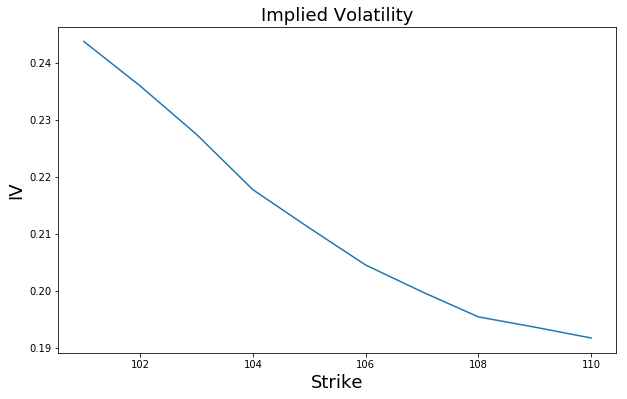

In [102]:
plt.figure(figsize=(10,6))
_=plt.plot(cboe_MSFT_call.strike,cboe_MSFT_call.implied_volatility_1545)
_=plt.xlabel('Strike', fontsize=18)
_=plt.ylabel('IV', fontsize=18)
_=plt.title('Implied Volatility',fontsize=18)

## 9.Задание

### 1. Выбрать для  анализа рынка опционов одну компанию. Для данной компании выбрать одну дату экспирации и сформировать цепочку страйков (примерно 5 страйков в каждую сторону от ATM).
### 2. Рассчитать теоретические стоимости опционов с помощью моделей CRR и BSM и сравнить их с рыночными ценами. 
### 3. Рассчитать параметры для двух опционных стратегий и визуализировать результат
### 4. Провести моделирование динамики цены акции и реализовать процедуру дельта-хеджирования
### 5. Расситать показатель IV для цепочки страйков
### 6. Сделать общие выводы по результатам проведенного исследования
